
EKSPERIMENT 1: KOMPARACIJA OPERATORA (Pc=0.8, Pm=0.02)

Rezultati za funkciju: ACKLEY
Ukrštanje    | Mutacija     | Srednji Fitness
---------------------------------------------
1-Point      | Bit-Flip     | 0.489711
1-Point      | Inversion    | 0.055504
1-Point      | Scramble     | 0.097723
2-Point      | Bit-Flip     | 0.453076
2-Point      | Inversion    | 0.289296
2-Point      | Scramble     | 0.240941
Uniform      | Bit-Flip     | 0.227695
Uniform      | Inversion    | 0.279512
Uniform      | Scramble     | 0.187126


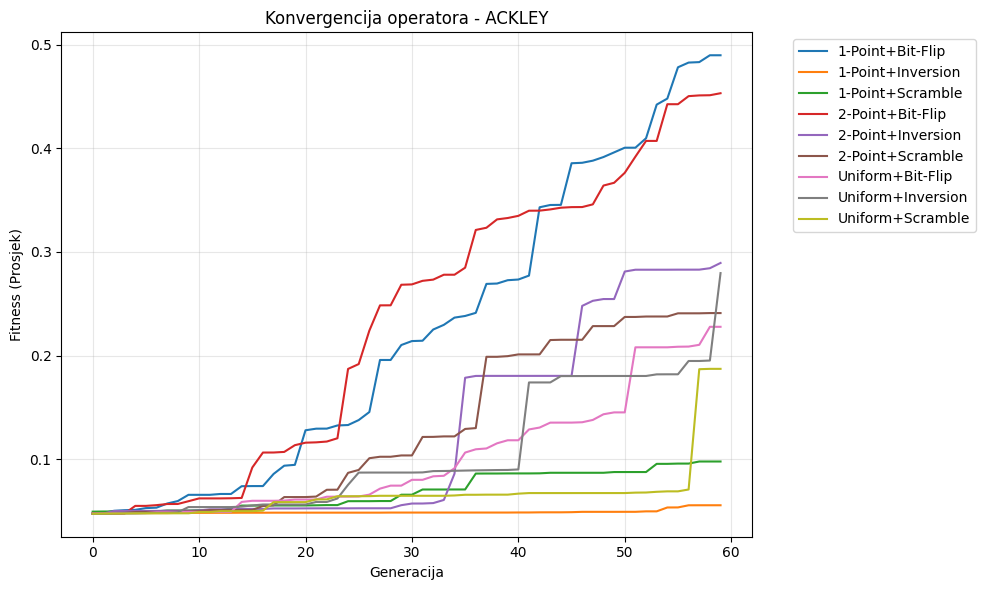


Rezultati za funkciju: SCHWEFEL
Ukrštanje    | Mutacija     | Srednji Fitness
---------------------------------------------
1-Point      | Bit-Flip     | 0.902564
1-Point      | Inversion    | 0.243548
1-Point      | Scramble     | 0.358559
2-Point      | Bit-Flip     | 0.903822
2-Point      | Inversion    | 0.606569
2-Point      | Scramble     | 0.490711
Uniform      | Bit-Flip     | 0.975943
Uniform      | Inversion    | 0.269420
Uniform      | Scramble     | 0.584076


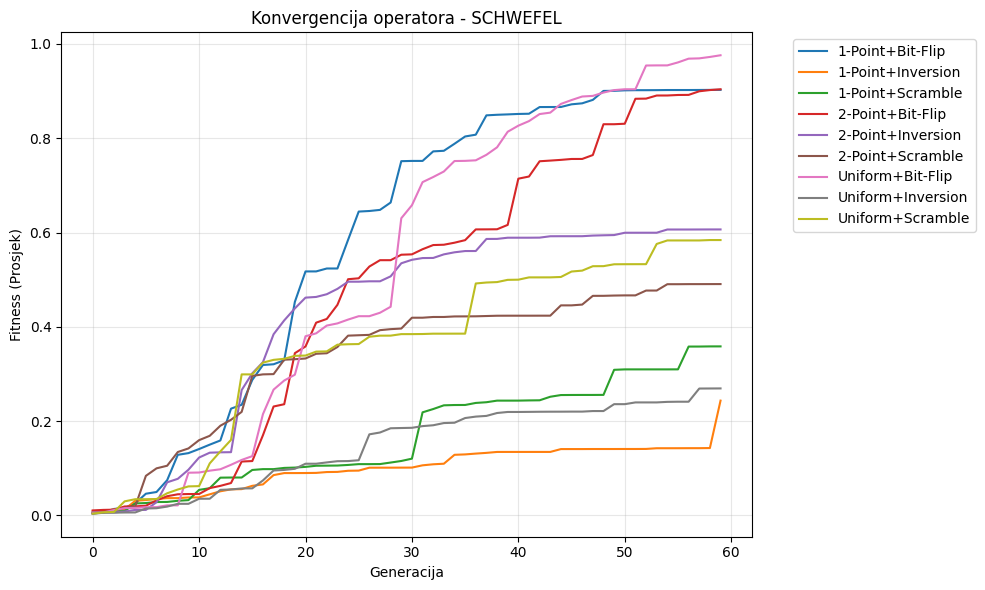


Rezultati za funkciju: GRIEWANK
Ukrštanje    | Mutacija     | Srednji Fitness
---------------------------------------------
1-Point      | Bit-Flip     | 0.967998
1-Point      | Inversion    | 0.818225
1-Point      | Scramble     | 0.852493
2-Point      | Bit-Flip     | 0.974646
2-Point      | Inversion    | 0.936313
2-Point      | Scramble     | 0.813821
Uniform      | Bit-Flip     | 0.983178
Uniform      | Inversion    | 0.976748
Uniform      | Scramble     | 0.980408


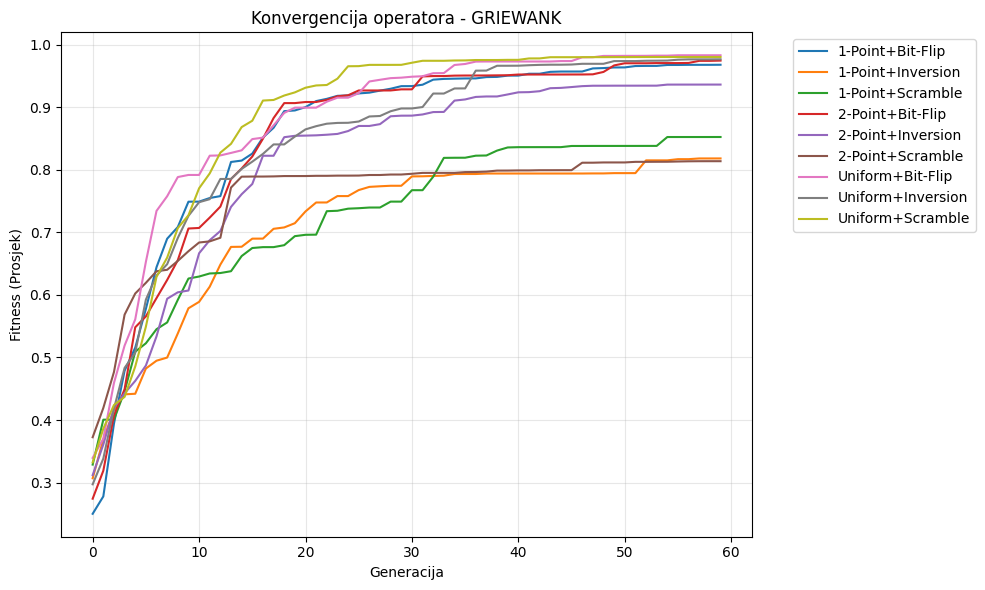


EKSPERIMENT 2: ANALIZA OSJETLJIVOSTI PARAMETARA (2-Point + Bit-Flip)

Rezultati za funkciju: ACKLEY (Analiza parametara)
Parametri                           | Srednji Fitness
-------------------------------------------------------
Standard (Pc=0.8, Pm=0.02)          | 0.301319
Konzervativno (Pc=0.95, Pm=0.005)   | 0.272376
Agresivno (Pc=0.6, Pm=0.1)          | 0.169508


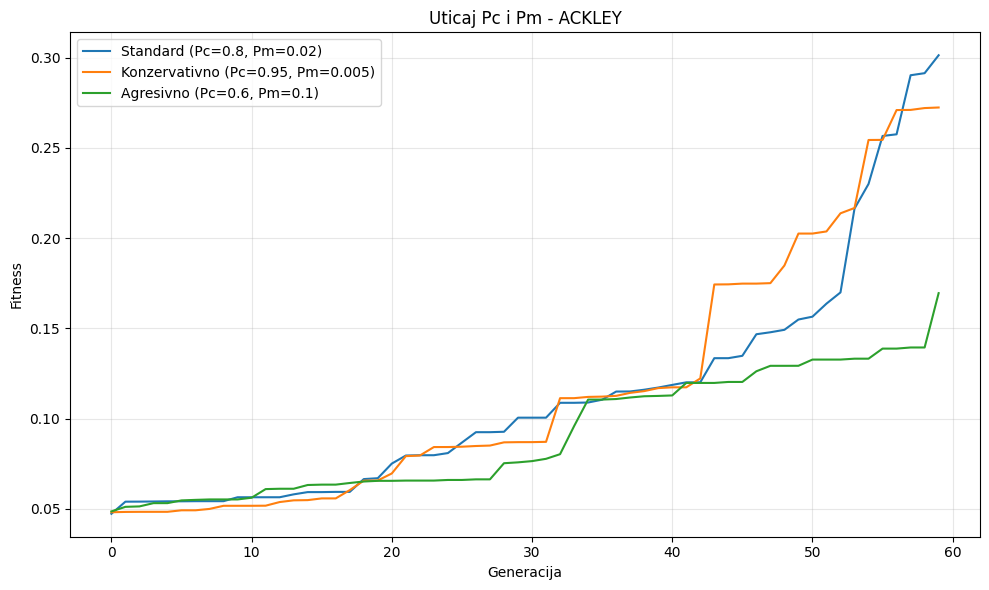


Rezultati za funkciju: SCHWEFEL (Analiza parametara)
Parametri                           | Srednji Fitness
-------------------------------------------------------
Standard (Pc=0.8, Pm=0.02)          | 0.986128
Konzervativno (Pc=0.95, Pm=0.005)   | 0.754180
Agresivno (Pc=0.6, Pm=0.1)          | 0.560852


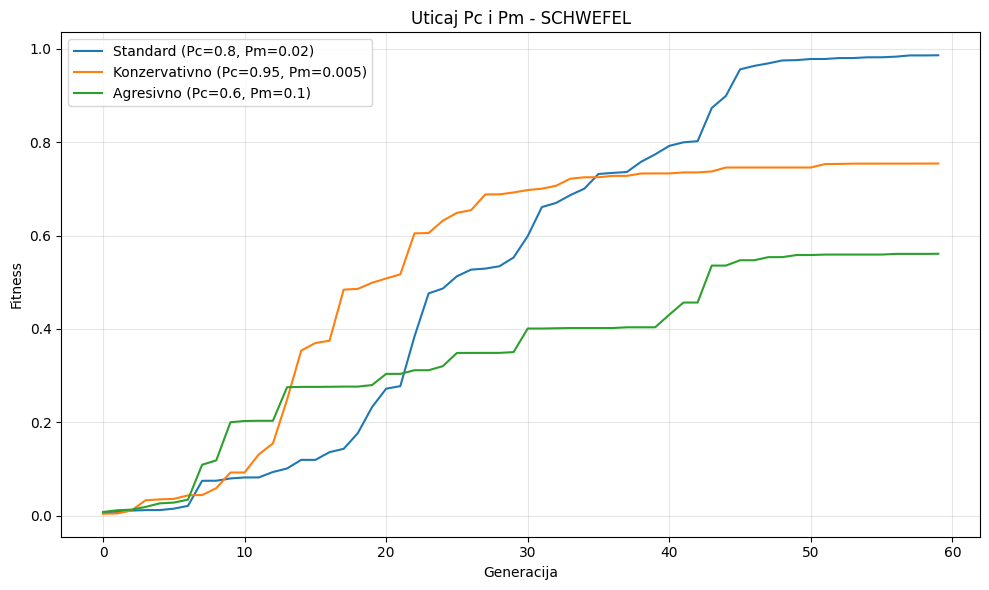


Rezultati za funkciju: GRIEWANK (Analiza parametara)
Parametri                           | Srednji Fitness
-------------------------------------------------------
Standard (Pc=0.8, Pm=0.02)          | 0.971807
Konzervativno (Pc=0.95, Pm=0.005)   | 0.935368
Agresivno (Pc=0.6, Pm=0.1)          | 0.916077


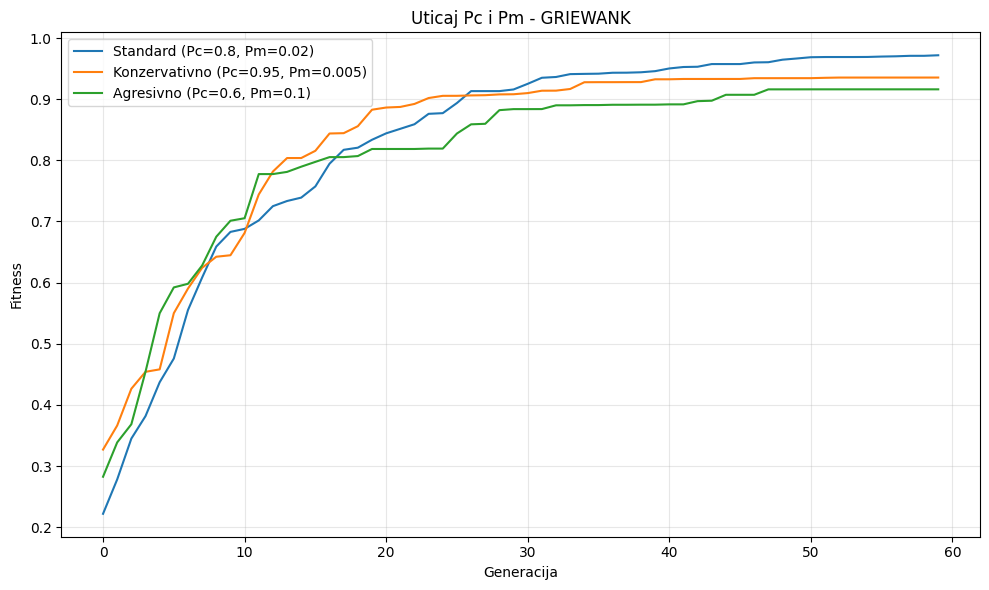

In [ ]:
import random as r
import copy
import math
import matplotlib.pyplot as plt

# PARAMETRI EKSPERIMENTA (Konstantni)
VEL_POP = 50
MAX_GEN = 60
ELITA = 1
RANG_SP = 1.5
DUZINA_HROM = 64      # 32 bita po varijabli
P_INT = 9             # Podržava Schwefel opseg do 512
RUNS = 8              # Broj ponavljanja za statističku stabilnost

# TESTNE FUNKCIJE
def f_Ackley(x):
    a, b, c = 20, 0.2, 2*math.pi
    x1, x2 = x
    t1 = -a * math.exp(-b * math.sqrt(0.5 * (x1**2 + x2**2)))
    t2 = -math.exp(0.5 * (math.cos(c*x1) + math.cos(c*x2)))
    return t1 + t2 + a + math.e

def f_Schwefel(x):
    return 418.9829 * len(x) - sum(v * math.sin(math.sqrt(abs(v))) for v in x)

def f_Griewank(x):
    sum_sq = sum(v**2 for v in x) / 4000
    prod = math.cos(x[0]) * math.cos(x[1] / math.sqrt(2))
    return sum_sq - prod + 1

# KLASA INDIVIDUA
class Individua:
    def __init__(self, funkcija, hromozom=None):
        self.funkcija = funkcija
        if hromozom is None:
            self.hromozom = [r.randint(0, 1) for _ in range(DUZINA_HROM)]
        else:
            self.hromozom = hromozom
        self.x = [0.0, 0.0]
        self.fitness = 0.0

    def _bin_to_real(self, bits):
        znak = -1 if bits[0] == 1 else 1
        cijeli_dio = int("".join(map(str, bits[1:1+P_INT])), 2)
        decimalni_dio = sum(bit * 2**-(i+1) for i, bit in enumerate(bits[1+P_INT:]))
        return znak * (cijeli_dio + decimalni_dio)

    def dekodiraj(self):
        sredina = DUZINA_HROM // 2
        return [self._bin_to_real(self.hromozom[:sredina]),
                self._bin_to_real(self.hromozom[sredina:])]

    def evaluiraj(self):
        self.x = self.dekodiraj()
        y = self.funkcija(self.x)
        self.fitness = 1 / (1 + y)
        return self.fitness

# OPERATORI
def selekcija_rang(pop):
    pop_sorted = sorted(pop, key=lambda i: i.fitness)
    N = len(pop_sorted)
    limit = r.random()
    s = 0.0
    for i in range(N):
        p = (1/N) * (2 - RANG_SP + 2 * (RANG_SP - 1) * i / (N - 1))
        s += p
        if s >= limit: return pop_sorted[i]
    return pop_sorted[-1]

def cross_1point(p1, p2):
    t = r.randint(1, DUZINA_HROM - 1)
    return Individua(p1.funkcija, p1.hromozom[:t] + p2.hromozom[t:]), \
           Individua(p1.funkcija, p2.hromozom[:t] + p1.hromozom[t:])

def cross_2point(p1, p2):
    t1, t2 = sorted(r.sample(range(DUZINA_HROM), 2))
    h1 = p1.hromozom[:t1] + p2.hromozom[t1:t2] + p1.hromozom[t2:]
    h2 = p2.hromozom[:t1] + p1.hromozom[t1:t2] + p2.hromozom[t2:]
    return Individua(p1.funkcija, h1), Individua(p1.funkcija, h2)

def cross_uniform(p1, p2):
    h1, h2 = [], []
    for i in range(DUZINA_HROM):
        if r.random() < 0.5:
            h1.append(p1.hromozom[i]); h2.append(p2.hromozom[i])
        else:
            h1.append(p2.hromozom[i]); h2.append(p1.hromozom[i])
    return Individua(p1.funkcija, h1), Individua(p1.funkcija, h2)

def mut_bitflip(ind, p_m):
    for i in range(DUZINA_HROM):
        if r.random() < p_m: ind.hromozom[i] = 1 - ind.hromozom[i]

def mut_inversion(ind, p_m):
    if r.random() < p_m:
        t1, t2 = sorted(r.sample(range(DUZINA_HROM), 2))
        ind.hromozom[t1:t2] = ind.hromozom[t1:t2][::-1]

def mut_scramble(ind, p_m):
    if r.random() < p_m:
        t1, t2 = sorted(r.sample(range(DUZINA_HROM), 2))
        seg = ind.hromozom[t1:t2]
        r.shuffle(seg)
        ind.hromozom[t1:t2] = seg

# GA ENGINE
def GA(funkcija, cross_func, mut_func, p_c, p_m):
    pop = [Individua(funkcija) for _ in range(VEL_POP)]
    for i in pop: i.evaluiraj()
    hist = []
    for _ in range(MAX_GEN):
        pop.sort(key=lambda i: i.fitness, reverse=True)
        hist.append(pop[0].fitness)
        nova = pop[:ELITA]
        while len(nova) < VEL_POP:
            p1, p2 = selekcija_rang(pop), selekcija_rang(pop)
            if r.random() < p_c:
                c1, c2 = cross_func(p1, p2)
            else:
                c1, c2 = copy.deepcopy(p1), copy.deepcopy(p2)
            mut_func(c1, p_m); mut_func(c2, p_m)
            c1.evaluiraj(); c2.evaluiraj()
            nova.extend([c1, c2])
        pop = nova[:VEL_POP]
    return pop[0], hist

# IZVRŠAVANJE EKSPERIMENATA
if __name__ == "__main__":
    test_funkcije = [("ACKLEY", f_Ackley), ("SCHWEFEL", f_Schwefel), ("GRIEWANK", f_Griewank)]
    ukrstanja = {"1-Point": cross_1point, "2-Point": cross_2point, "Uniform": cross_uniform}
    mutacije = {"Bit-Flip": mut_bitflip, "Inversion": mut_inversion, "Scramble": mut_scramble}

    # --- EKSPERIMENT 1: KOMPARACIJA OPERATORA ---
    print("\n" + "="*70)
    print("EKSPERIMENT 1: KOMPARACIJA OPERATORA (Pc=0.8, Pm=0.02)")
    print("="*70)

    for f_name, f_curr in test_funkcije:
        plt.figure(figsize=(10, 6))
        print(f"\nRezultati za funkciju: {f_name}")
        print(f"{'Ukrštanje':<12} | {'Mutacija':<12} | {'Srednji Fitness'}")
        print("-" * 45)

        for u_name, u_func in ukrstanja.items():
            for m_name, m_func in mutacije.items():
                istorije = []
                for _ in range(RUNS):
                    _, h = GA(f_curr, u_func, m_func, 0.8, 0.02)
                    istorije.append(h)

                avg_h = [sum(g)/RUNS for g in zip(*istorije)]
                print(f"{u_name:<12} | {m_name:<12} | {avg_h[-1]:.6f}")
                plt.plot(avg_h, label=f"{u_name}+{m_name}")

        plt.title(f"Konvergencija operatora - {f_name}")
        plt.xlabel("Generacija")
        plt.ylabel("Fitness (Prosjek)")
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()

    # --- EKSPERIMENT 2: ANALIZA OSJETLJIVOSTI (Pc i Pm) ---
    print("\n" + "="*70)
    print("EKSPERIMENT 2: ANALIZA OSJETLJIVOSTI PARAMETARA (2-Point + Bit-Flip)")
    print("="*70)

    p_setovi = [
        (0.8, 0.02, "Standard (Pc=0.8, Pm=0.02)"),
        (0.95, 0.005, "Konzervativno (Pc=0.95, Pm=0.005)"),
        (0.6, 0.1, "Agresivno (Pc=0.6, Pm=0.1)")
    ]

    for f_name, f_curr in test_funkcije:
        plt.figure(figsize=(10, 6))
        print(f"\nRezultati za funkciju: {f_name} (Analiza parametara)")
        print(f"{'Parametri':<35} | {'Srednji Fitness'}")
        print("-" * 55)

        for pc, pm, label_name in p_setovi:
            istorije = []
            for _ in range(RUNS):
                _, h = GA(f_curr, cross_2point, mut_bitflip, pc, pm)
                istorije.append(h)

            avg_h = [sum(g)/RUNS for g in zip(*istorije)]
            print(f"{label_name:<35} | {avg_h[-1]:.6f}")
            plt.plot(avg_h, label=label_name)

        plt.title(f"Uticaj Pc i Pm - {f_name}")
        plt.xlabel("Generacija")
        plt.ylabel("Fitness")
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()